# Dimension Reduction

by Chris North, Virginia Tech

Topics:  MDS, PCA

Datasets: Animal_Type.csv


## Dimension Reduction concepts
* Goal: Reduce p of a big table, compute $k<p$ new columns that approximate all p columns.
    * Typically k=2 or 3 for scatterplot visualization
* Projection:  flashlight analogy 
    * Is it accurate?
    * Whats the best projection?
* Common methods:  MDS, PCA, t-SNE, UMAP, ...
    * Interactive comparisons: https://observablehq.com/@3e787c1af6c5a437/a-comparative-overview-of-dimension-reduction-methods
* https://en.wikipedia.org/wiki/Dimensionality_reduction



## Multi-Dimensional Scaling (MDS)
* https://en.wikipedia.org/wiki/Multidimensional_scaling
* Goal: visualize the distances between points
* Given: 
    * high-dimensional distance matrix, with distances $d_{ij}$ between all rows $i$ and $j$ of a data table, 
    * low-dimensional euclidean distance function $||p_i - p_j||$,
* Find:
    * low-dimensional points $p_i$ 
    * that minimize the total error in pairwise distances, called the Stress function:
        * $Stress = \left(\large \frac{\sum_{i,j}{(d_{ij} - ||p_i - p_j||)^2}}{\sum_{i,j}{d_{ij}^2}} \right) ^{1/2}$
        * stress == 0 &rarr; perfect projection
        * stress == 1 &rarr; null projection, all $p_i==p_j$
* Optimization algorithm: 
    1. randomly initialize all $p_i$
    2. gradient descent to local minimum:
        1. compute force vector on each point $p_i$
        2. nudge each point $p_i$ by its force vector
        3. re-compute Stress
        4. lower Stress? go to A, until $max\_iter$
    3. save result
    3. go to 1, until $n\_init$
    4. select result with lowest Stress
* $O(n^2 * max\_iter * n\_init)$
* Generalizable to various distance functions
* Relative distances, scale & rotation invariant


### MDS theory exercise


In [2]:
### data for in-class exercise
import pandas
dataHD = pandas.DataFrame(
    [[0,0,0,0],[1,1,1,1],[1,1,1,2],[0,1,3,1]],
    index=['A','B','C','D'], columns=['C1','C2','C3','C4'])
dataHD

,C1,C2,C3,C4
A,0,0,0,0
B,1,1,1,1
C,1,1,1,2
D,0,1,3,1


#### Compute an MDS approximation by hand:

1. Fill in the L1 distance matrix for multi-dimensional rows A,B,C,D.  (no normalization)



|   | A | B | C | D |
|---|---|---|---|---|
| A | 0 |   |   |   |
| B | 4 | 0 |   |   |
| C | 5 | 1 | 0 |   |
| D | 5 | 3 | 4 | 0 |


2. Draw the points in 2D as best you can to preserve pairwise distances.



<pre>
y
|
| A      B  C
|                  
|
|                  
|       D
+-------------------- x
</pre>

3. What are the 2D coordinates of your drawn 2D points?



|   | x | y | 
|---|---|---|
| A | 0 | 4 |
| B | 4 | 4 |
| C | 5 | 5 |
| D | 4 | 0 |


4. Fill in the L2 Euclidean distance matrix for your drawn 2D points.



|   | A | B | C | D |
|---|---|---|---|---|
| A | 0 |   |   |   |
| B | 4 | 0 |   |   |
| C | 6 | 1 | 0 |   |
| D | 5 | 4 | 4 | 0 |


5. What is the total Stress of your 2D drawing?

$Stress = \left(\Large \frac{\sum_{i,j}{(d_{ij} - ||p_i - p_j||)^2}}{\sum_{i,j}{d_{ij}^2}} \right) ^{1/2}$



Stress = 0.15


In [3]:
(2 / (4**2 + 5 ** 2 + 5 ** 2 + 1 + 3 ** 2 + 4 ** 2)) ** 0.5

0.14744195615489714

### Computational solution:

* scikit-learn library: http://scikit-learn.org/ 
* MDS: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 
* distances: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise 


In [3]:
## L1 high-dimensional Distance Matrix 
import sklearn.metrics.pairwise

distHD = sklearn.metrics.pairwise.manhattan_distances(dataHD)
distHD = pandas.DataFrame(distHD, columns=dataHD.index, index=dataHD.index )
distHD

,A,B,C,D
A,0.0,4.0,5.0,5.0
B,4.0,0.0,1.0,3.0
C,5.0,1.0,0.0,4.0
D,5.0,3.0,4.0,0.0


In [17]:
## Dimension Reduction with MDS
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
data2D = mds.fit_transform(distHD)
data2D = pandas.DataFrame(data2D, columns=['x', 'y'], index=dataHD.index)
data2D

,x,y
A,-2.206880,2.420670
B,-0.077155,-1.024468
C,-0.194165,-2.121498
D,2.478200,0.725296


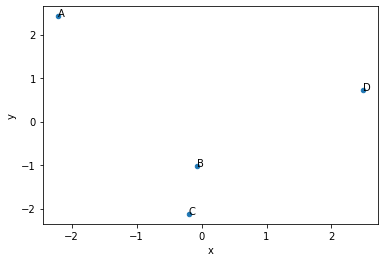

In [18]:
## Plot the MDS 2D result
ax = data2D.plot.scatter('x', 'y')
for i, r in data2D.iterrows():
    ax.text(r.x, r.y, i)

### Compute the Stress

$Stress = \left(\Large \frac{\sum_{i,j}{(d_{ij} - ||p_i - p_j||)^2}}{\sum_{i,j}{d_{ij}^2}} \right) ^{1/2}$

Stress < 0.1 is a very good fit

In [19]:
distHD

,A,B,C,D
A,0.0,4.0,5.0,5.0
B,4.0,0.0,1.0,3.0
C,5.0,1.0,0.0,4.0
D,5.0,3.0,4.0,0.0


In [20]:
## 2D euclidean distances in the plot
dist2D = sklearn.metrics.pairwise.euclidean_distances(data2D)
dist2D = pandas.DataFrame(dist2D, index=data2D.index, columns=data2D.index)
dist2D

,A,B,C,D
A,0.000000,4.050272,4.968130,4.982396
B,4.050272,0.000000,1.103252,3.097017
C,4.968130,1.103252,0.000000,3.904583
D,4.982396,3.097017,3.904583,0.000000


In [21]:
## Distance error
distHD - dist2D

,A,B,C,D
A,0.000000,-0.050272,0.031870,0.017604
B,-0.050272,0.000000,-0.103252,-0.097017
C,0.031870,-0.103252,0.000000,0.095417
D,0.017604,-0.097017,0.095417,0.000000


In [22]:
## Stress function
((((distHD - dist2D) ** 2).sum().sum()) / (distHD ** 2).sum().sum()) ** 0.5

0.018948066294410076

## Exercise

Use MDS to reduce the Animal data to 2D and plot it. 


In [23]:
### Dimension Reduction exercise
import pandas
table = pandas.read_csv('data/Animal_Type.csv').set_index('Name').sort_index()
colors = {'Air':'red', 'Land':'green', 'Water':'blue'}
table

,Type,Active,Agility,Arctic,Bipedal,Bulbous,Coastal,Domestic,Fierce,Forager,...,Size,Smart,Speed,Spots,Stalker,Strength,Tail,Timid,Toughskin,Water
Name,,,,,,,,,,,,,,,,,,,,,
Bat,Air,36.24,42.11,0.00,23.75,15.28,9.38,5.56,32.57,24.38,...,1.25,32.30,80.96,1.25,8.12,7.50,15.11,8.98,30.00,1.39
Beaver,Water,67.81,36.25,11.25,12.50,37.50,33.75,13.12,3.75,10.62,...,6.88,41.88,25.00,7.50,1.25,32.81,86.56,31.88,25.00,65.62
Blue Whale,Water,7.88,7.06,32.75,0.00,65.15,5.31,5.00,7.50,0.00,...,86.46,39.06,21.42,23.75,0.00,55.26,26.42,44.58,45.17,76.61
Bobcat,Land,61.13,71.74,6.67,0.00,0.00,1.39,3.75,71.95,36.97,...,19.93,42.89,73.97,33.55,66.98,32.99,64.50,0.00,2.50,0.00
Buffalo,Land,18.94,4.38,0.00,0.00,50.83,0.00,2.31,26.99,23.67,...,84.91,10.00,24.79,0.00,0.00,50.81,5.39,19.88,42.36,9.38
Chihuahua,Land,56.13,20.24,0.00,3.12,0.62,1.51,73.55,33.03,3.20,...,0.00,29.84,27.87,11.79,1.38,4.30,48.80,36.73,0.62,1.25
Chimpanzee,Land,77.80,75.86,1.25,66.82,6.56,8.75,36.62,23.10,33.53,...,28.29,84.36,56.94,0.00,8.75,41.19,54.26,29.64,20.96,1.25
Collie,Land,54.26,32.05,0.00,0.62,8.07,6.25,79.11,5.25,6.16,...,26.31,42.17,49.05,9.09,3.75,19.55,67.09,43.09,1.25,0.00
Cow,Land,20.93,16.06,0.00,0.00,35.81,8.76,72.99,3.34,5.24,...,68.31,13.97,10.89,31.35,0.00,47.02,62.77,47.87,42.45,0.55


In [24]:
### Normalize
quant = table.drop(columns='Type')
norm = (quant - quant.mean())/quant.std()
norm.head()

,Active,Agility,Arctic,Bipedal,Bulbous,Coastal,Domestic,Fierce,Forager,Forest,...,Size,Smart,Speed,Spots,Stalker,Strength,Tail,Timid,Toughskin,Water
Name,,,,,,,,,,,,,,,,,,,,,
Bat,-0.122237,0.321313,-0.515129,0.845275,-0.533534,-0.054466,-0.764903,0.223928,0.160911,1.494360,...,-1.214116,-0.087187,1.626449,-0.588277,-0.267344,-1.163772,-1.349291,-1.047946,0.243343,-0.506743
Beaver,1.310382,0.067700,-0.008944,0.193449,0.428509,1.742710,-0.481470,-0.953782,-0.657530,-0.172810,...,-1.049261,0.424085,-0.743989,-0.296388,-0.545909,-0.192710,1.699393,0.150570,0.014479,1.758646
Blue Whale,-1.409188,-1.195602,0.958432,-0.530802,1.625650,-0.354610,-0.785898,-0.800541,-1.289204,-0.988632,...,1.280968,0.273585,-0.895636,0.462524,-0.596594,0.668622,-0.866708,0.815250,0.937717,2.146262
Bobcat,1.007250,1.603658,-0.215017,-0.530802,-1.195100,-0.643692,-0.832762,1.833167,0.909760,0.336116,...,-0.667136,0.477987,1.330356,0.920206,2.119315,-0.185804,0.758120,-1.517933,-1.015410,-0.555768
Buffalo,-0.907295,-1.311589,-0.515129,-0.530802,1.005648,-0.746198,-0.886749,-0.004095,0.118680,-0.988632,...,1.235581,-1.277308,-0.752884,-0.646655,-0.596594,0.497890,-1.764032,-0.477473,0.809096,-0.224936


In [25]:
## L1 Distance Matrix 
distHD = sklearn.metrics.pairwise.manhattan_distances(norm)
distHD = pandas.DataFrame(distHD, columns=norm.index, index=norm.index)
distHD

Name,Bat,Beaver,Blue Whale,Bobcat,Buffalo,Chihuahua,Chimpanzee,Collie,Cow,Dalmatian,...,Sheep,Siamese Cat,Skunk,Spider Monkey,Squirrel,Tiger,Walrus,Weasel,Wolf,Zebra
Name,,,,,,,,,,,,,,,,,,,,,
Bat,0.000000,42.694329,47.937600,41.067986,42.273772,43.541375,36.968314,45.664907,45.936855,46.395297,...,44.261299,37.741702,40.309289,38.801268,38.848045,48.102902,48.902628,30.879281,43.497873,39.657721
Beaver,42.694329,0.000000,35.301429,40.374104,35.882419,29.567531,41.889934,28.418511,35.525258,34.971212,...,41.079966,35.970323,25.686555,31.787191,26.351736,49.982033,34.409467,31.487801,41.728716,40.348471
Blue Whale,47.937600,35.301429,0.000000,59.528135,24.858011,40.480007,55.864817,40.415841,28.415066,39.882635,...,35.587322,51.139569,44.103296,48.378127,52.865884,61.218159,18.216568,44.925734,57.895409,40.121371
Bobcat,41.067986,40.374104,59.528135,0.000000,50.778898,36.119131,37.639683,32.854530,51.807144,38.496037,...,49.939847,29.624374,37.434991,31.381241,35.642698,25.074115,63.356490,24.426490,16.969005,41.455553
Buffalo,42.273772,35.882419,24.858011,50.778898,0.000000,32.820248,46.736852,35.067798,20.493318,38.273309,...,22.629807,42.746073,31.516899,40.079442,44.331135,54.248480,28.078704,34.720149,49.996007,28.110537
Chihuahua,43.541375,29.567531,40.480007,36.119131,32.820248,0.000000,40.449534,14.130425,28.338189,20.074298,...,29.440846,21.105268,23.183701,30.772870,30.316074,45.190307,43.428820,25.602128,38.841780,32.071027
Chimpanzee,36.968314,41.889934,55.864817,37.639683,46.736852,40.449534,0.000000,34.613079,44.860105,39.603404,...,46.791242,36.201771,43.113789,20.579078,31.476970,42.829157,58.156820,35.315695,35.421903,36.248136
Collie,45.664907,28.418511,40.415841,32.854530,35.067798,14.130425,34.613079,0.000000,27.504925,20.031805,...,29.782141,22.304294,26.019611,28.528609,26.771457,42.189315,44.590330,25.169008,34.219619,29.681946
Cow,45.936855,35.525258,28.415066,51.807144,20.493318,28.338189,44.860105,27.504925,0.000000,31.104985,...,20.383136,37.165211,33.527334,42.835538,41.974353,54.869025,33.188759,42.057695,51.715370,26.578786


In [42]:
## MDS
mds = sklearn.manifold.MDS(
    n_components=2, dissimilarity='precomputed', max_iter=1000, n_init=100)
data2D = mds.fit_transform(distHD)
data2D = pandas.DataFrame(data2D, columns=['x', 'y'], index=norm.index)
data2D

,x,y
Name,,
Bat,33.800569,-1.259658
Beaver,16.680459,-14.757720
Blue Whale,-13.331514,-29.604291
Bobcat,22.277990,26.407351
Buffalo,-13.764107,-14.749441
Chihuahua,1.546943,3.095910
Chimpanzee,-10.466017,31.239333
Collie,1.953818,6.765751
Cow,-17.325347,-8.179965


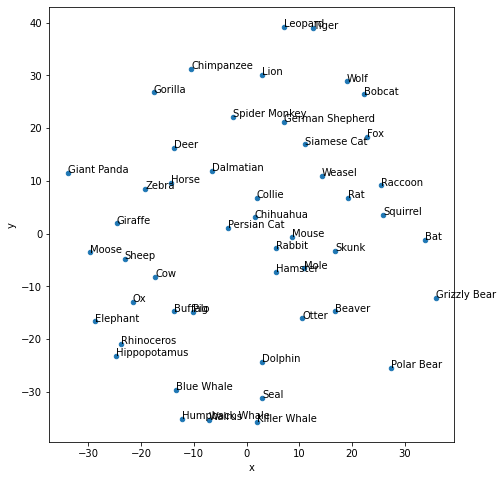

In [43]:
## Plot the 2D
ax = data2D.plot.scatter('x', 'y', figsize=(8,8))
ax.axis('scaled')
for i, r in data2D.iterrows():
    ax.text(r.x, r.y, i)

In [44]:
dist2D = sklearn.metrics.pairwise.euclidean_distances(data2D)
dist2D = pandas.DataFrame(dist2D, columns=norm.index, index=norm.index)
dist2D

Name,Bat,Beaver,Blue Whale,Bobcat,Buffalo,Chihuahua,Chimpanzee,Collie,Cow,Dalmatian,...,Sheep,Siamese Cat,Skunk,Spider Monkey,Squirrel,Tiger,Walrus,Weasel,Wolf,Zebra
Name,,,,,,,,,,,,,,,,,,,,,
Bat,0.000000,21.801280,54.998650,29.970539,49.440597,32.546388,54.915527,32.842392,51.592149,42.493412,...,57.060004,29.086980,17.107364,43.338826,9.266278,45.407298,53.311018,23.100087,33.585703,53.958107
Beaver,21.801280,0.000000,33.483417,41.543898,30.444568,23.404603,53.410299,26.079374,34.636133,35.427912,...,41.037614,32.163051,11.477395,41.691161,20.475857,53.831342,31.523276,25.886811,43.716335,42.798278
Blue Whale,54.998650,33.483417,0.000000,66.372741,14.861148,35.925919,60.911063,39.451506,21.793404,42.109894,...,26.619330,52.541696,40.020067,52.873670,51.336768,73.288401,8.463142,49.085660,66.847538,38.520943
Bobcat,29.970539,41.543898,66.372741,0.000000,54.707534,31.196147,33.098612,28.264190,52.580478,32.275123,...,55.145022,14.670382,30.187234,25.286671,23.149729,15.788119,68.447076,17.371152,4.104072,45.265802
Buffalo,49.440597,30.444568,14.861148,54.707534,0.000000,23.513503,46.106883,26.645012,7.472646,27.659163,...,13.631280,40.255548,32.657093,38.564604,43.652882,59.821453,21.672118,38.044423,54.583873,23.850288
Chihuahua,32.546388,23.404603,35.925919,31.196147,23.513503,0.000000,30.600056,3.692327,21.984282,12.029372,...,25.942772,16.795731,16.544493,19.540513,24.330393,37.508992,39.456051,14.951367,31.157366,21.501347
Chimpanzee,54.915527,53.410299,60.911063,33.098612,46.106883,30.600056,0.000000,27.444645,40.011641,19.664915,...,38.261615,25.882202,43.997810,11.963370,45.693347,24.362961,66.710454,31.921988,29.573724,24.427977
Collie,32.842392,26.079374,39.451506,28.264190,26.645012,3.692327,27.444645,0.000000,24.393864,9.994258,...,27.661340,13.657509,17.936997,16.087665,24.136220,33.890437,43.127246,12.990292,27.943408,21.296710
Cow,51.592149,34.636133,21.793404,52.580478,7.472646,21.984282,40.011641,24.393864,0.000000,22.826709,...,6.700569,37.912172,34.488103,33.719402,44.759878,55.833766,29.047940,36.933964,51.915774,16.749167


In [45]:
## Compute correct Stress
((((distHD - dist2D) ** 2).sum().sum()) / (distHD ** 2).sum().sum()) ** 0.5

0.24758935551722344

In [41]:
distHD['Polar Bear']

Name
Bat                50.949622
Beaver             38.519363
Blue Whale         44.719805
Bobcat             44.951426
Buffalo            35.731985
Chihuahua          45.714237
Chimpanzee         57.169718
Collie             44.392405
Cow                48.952886
Dalmatian          52.234287
Deer               57.630314
Dolphin            48.788363
Elephant           50.642982
Fox                42.961722
German Shepherd    42.475361
Giant Panda        44.327002
Giraffe            53.175508
Gorilla            43.687404
Grizzly Bear       29.701897
Hamster            38.892183
Hippopotamus       46.467663
Horse              54.939901
Humpback Whale     44.677869
Killer Whale       40.722835
Leopard            51.608767
Lion               36.126971
Mole               36.681009
Moose              46.412877
Mouse              49.097589
Otter              36.369040
Ox                 46.434286
Persian Cat        43.717440
Pig                41.623118
Polar Bear          0.000000
Rabbit   

### Exercise

Sort a data table based on row similarity.

## Weighted Multi-Dimensional Scaling (wMDS)
* Interactive, allow analyst to emphasize some columns by specifying column weights.
* MDS with weighted distance functions
    * Apply a weight $w_i$ to each data column $i$ that represents their importances
    * Weighted L1:  $dist(P,Q) = \sum_i w_i|P_i-Q_i|$
* Forward projection:  Given the dimension weights, find the projection that minimizes the error in weighted pairwise distances.
* Inverse projection:  Given a user modified projection, find the dimension weights that would best produce that projection.
* Andromeda interactive wMDS visualization: 
    * Andromeda in Jupyter: https://github.com/infovis-vt/AndromedaJupyter
    * Andromeda Online: http://nebula.cs.vt.edu/cosmos/andromeda.html
    * Instructions: http://infovis.cs.vt.edu/content/web-andromeda-instructions
    * Info: http://infovis.cs.vt.edu/andromeda


## Principal Component Analysis (PCA)

* https://en.wikipedia.org/wiki/Principal_component_analysis
* Compute new axes (principal components): 
    * linear combinations of the columns (e.g. a rotation of axes)
    * orthogonal to each other
    * maximize explained variance
    * choose the first 2 or 3 PCs for visualization.
* Conceptual algorithm: Find orthogonal axes that capture maximum variance
    1. Rotate the data such that the maximum variance is on X
    2. Project onto X, save as $PC_i$
    2. Project out X
    3. Go to 1
* Computational algorithm:
    1. Compute correlation matrix
    2. Compute eigenvectors, eigenvalues
    3. Select eigenvectors for largest k eigenvalues
        * explained variance == eigenvalues
    4. Project data onto these eigenvectors
* Scree-plot of Explained Variance 
    * https://en.wikipedia.org/wiki/Scree_plot
* $O(n * p^2)$
* Assumes L2 distance

* Python PCA: http://scikit-learn.org/stable/modules/decomposition.html#pca


In [48]:
## PCA
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
tablePCA = pca.fit_transform(norm)
tablePCA = pandas.DataFrame(tablePCA, index = norm.index)
tablePCA

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
Name,,,,,,,,,,,,,,,,,,,,,
Bat,-1.787914,0.684099,0.999696,1.718903,3.168175,-1.669465,-2.685171,0.930436,2.690962,2.305371,...,-0.353495,0.124964,-0.004270,-0.086913,0.222470,0.011563,-0.147563,0.068057,-0.068204,-0.057597
Beaver,0.077271,-0.972668,3.500381,-0.299892,0.268628,1.078026,0.279187,-1.099074,-0.472327,-1.294619,...,-0.338994,0.057288,0.122937,-0.114525,0.025976,-0.022471,-0.029332,0.001070,0.045649,-0.151222
Blue Whale,5.334859,1.749788,1.287881,-0.727633,0.464428,-0.200405,-0.324868,1.011896,0.629457,-0.372288,...,0.288519,-0.148481,-0.002115,0.051889,-0.229217,-0.232172,-0.043884,0.149865,-0.055949,0.023418
Bobcat,-5.357721,1.831263,-0.020794,0.231925,-0.868581,-1.973579,0.354636,0.223022,-0.154200,0.315899,...,0.190769,-0.063190,0.076527,-0.221584,0.132280,0.056235,-0.003868,0.130201,0.020504,0.057377
Buffalo,3.230122,-0.334261,-1.091556,1.360845,-0.151106,-1.575233,0.368859,-0.339487,-0.127673,-0.828605,...,-0.265305,0.297615,0.271364,-0.428988,0.064348,0.119863,-0.045445,-0.026733,0.076088,0.114339
Chihuahua,-0.782238,-2.839448,0.336296,-1.681580,-2.221164,0.758298,-0.174937,0.481243,0.694171,-0.128327,...,0.181853,0.341109,-0.006365,-0.185758,-0.183973,-0.119472,-0.274612,0.054935,-0.102937,-0.072289
Chimpanzee,-3.501276,0.712566,-1.137181,-0.469141,4.290562,3.372278,1.233151,-0.060426,1.021577,0.354081,...,0.266368,-0.248189,0.019353,-0.225845,-0.106411,-0.040997,0.026333,-0.040433,-0.045048,-0.020126
Collie,-1.253091,-2.445120,0.397544,-1.872037,-1.604752,0.976184,1.081451,-0.178563,0.490071,-0.182374,...,-0.331801,-0.005483,-0.306921,-0.195230,0.382654,0.130083,0.269932,0.000269,-0.131371,0.065814
Cow,3.129304,-1.835129,-1.943010,-0.667699,-0.779423,-0.235646,0.915989,-0.546792,0.876710,-0.151793,...,0.161584,0.025720,-0.389588,-0.376422,-0.103563,0.103687,0.019637,0.107423,0.110950,-0.002473


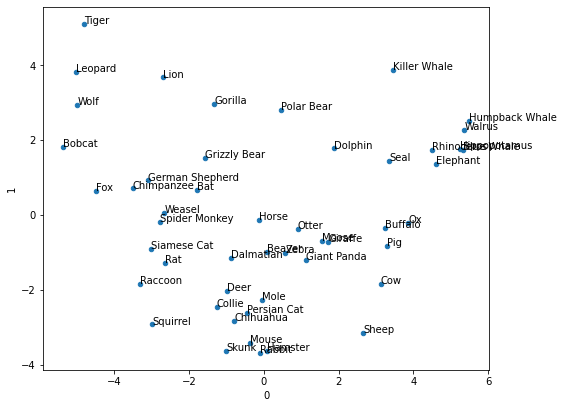

In [49]:
## Plot the first 2 PCs as x,y
ax = tablePCA.plot.scatter(0, 1, figsize=(8,8))
ax.axis('scaled')
for i, r in tablePCA.iterrows():
    ax.text(r[0], r[1], i)

In [50]:
## Ratio of Explained Variance by each PC
pca.explained_variance_ratio_

array([2.65244039e-01, 1.42694950e-01, 1.10905281e-01, 9.61110824e-02,
       6.74820395e-02, 5.42212832e-02, 4.48155345e-02, 2.99485677e-02,
       2.75763198e-02, 2.38994981e-02, 2.20542900e-02, 1.84994193e-02,
       1.66528802e-02, 1.04816482e-02, 9.84873917e-03, 9.14239312e-03,
       7.66148727e-03, 6.53358472e-03, 5.57713564e-03, 4.47489584e-03,
       4.21471615e-03, 3.63697800e-03, 3.34482819e-03, 3.02683385e-03,
       2.74520290e-03, 1.90350153e-03, 1.42935190e-03, 1.39932360e-03,
       1.20026568e-03, 9.30626558e-04, 6.69070737e-04, 4.92188940e-04,
       4.25731995e-04, 2.99617845e-04, 2.92736235e-04, 1.63957538e-04])

<BarContainer object of 36 artists>

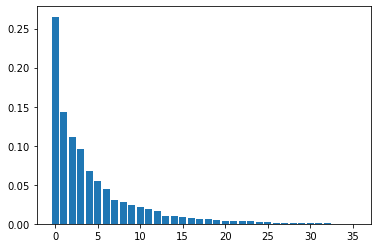

In [51]:
## Scree plot
import matplotlib
matplotlib.pyplot.bar(tablePCA.columns, pca.explained_variance_ratio_)

In [ ]:
## Linear combinations